<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Generate-jet-images" data-toc-modified-id="Generate-jet-images-1">Generate jet images</a></span><ul class="toc-item"><li><span><a href="#plot-some-jets" data-toc-modified-id="plot-some-jets-1.1">plot some jets</a></span></li></ul></li><li><span><a href="#Training-neural-networks" data-toc-modified-id="Training-neural-networks-2">Training neural networks</a></span><ul class="toc-item"><li><span><a href="#run-on-Colab" data-toc-modified-id="run-on-Colab-2.1">run on Colab</a></span></li><li><span><a href="#analyze" data-toc-modified-id="analyze-2.2">analyze</a></span><ul class="toc-item"><li><span><a href="#Check-effect-of-pixel-normalization" data-toc-modified-id="Check-effect-of-pixel-normalization-2.2.1">Check effect of pixel normalization</a></span></li><li><span><a href="#Compare-to-high-pT-jets" data-toc-modified-id="Compare-to-high-pT-jets-2.2.2">Compare to high pT jets</a></span></li></ul></li></ul></li></ul></div>

See details and walkthrough for this notebook at https://ilmonteux.github.io/2018/10/15/jet-tagging-cnn.html

# Load libraries and functions

In [6]:
import sys, os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

#from pythia_to_images import *

In [18]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np

# find pythia path so you can import it
pythia_path = '/Users/mghasemi/Desktop/Code-factory/pythia8310/'
cfg = open(pythia_path+"examples/Makefile.inc")
lib = pythia_path+"lib"
for line in cfg:
    if line.startswith("PREFIX_LIB="): lib = line[11:-1]; break
sys.path.insert(0, lib)
import pythia8

etaedges = np.arange(-3,3+0.01,0.12)
phiedges = np.arange(-np.pi*4/3,np.pi*4/3+0.01,np.pi/18.)
cmap = plt.get_cmap('gray_r')
PTCUT = 50.
nevents = 50000

"""
Write two Madgraph cards for production of ttbar and jj events.
Apply generator-level cut on the particle momenta given by PTRANGE,
allowing for a tolerance delta. If argument extra is specified, 
append it to output directories
"""
def write_mg_cards(PTRANGE, delta=10, nevents=200000, extra=''):
    with open('generate_tt.mg5','w') as f:
        f.write("""
    generate p p > t t~
    output jets_tt{3}
    launch
    madspin=none
    done
    set nevents {2}
    set pt_min_pdg {{ 6: {0} }}
    set pt_max_pdg {{ 6: {1} }}
    decay t > w+ b, w+ > j j
    decay t~ > w- b~, w- > j j
    done    
    """.format(PTRANGE[0]-delta, PTRANGE[1]+delta, nevents, extra))

    with open('generate_qcd.mg5','w') as f:
        f.write("""
    generate p p > j j
    output jets_qcd{3}
    launch
    done
    set nevents {2}
    set ptj {0}
    set ptjmax {1}
    done    
    """.format(PTRANGE[0]-delta, PTRANGE[1]+delta, nevents, extra))


"""
If a jet center is close to either 0 or 2*pi, its constituents could be on the other side
of the periodicity line. This takes care of this problem by remapping phi to be either
above 2*pi or below zero.
"""
def extend_jet_phi(phi, jet_phi):
    if abs(jet_phi + np.pi)<1.: # phi close to -pi
        return phi-2*np.pi*int(abs(phi-np.pi) <1-abs(jet_phi + np.pi))
    elif abs(jet_phi - np.pi)<1.: # phi close to pi
        return phi+2*np.pi*int(abs(-phi-np.pi) < 1-abs(jet_phi - np.pi)) 
    else: 
        return phi


""" 
Jet and constituents are passed as pythia vec4 objects.
Restricts image grid to within a DeltaR=1.2 range around jet center.
Returns pT-weighted histogram, and tuple with histogram grid.
"""
def make_image_leading_jet(leading_jet, leading_jet_constituents):
    jet_phi = leading_jet.phi()
    jet_eta = leading_jet.eta()
    ### redefine grid to only be Delta R=1 around jet center
    yedges = [phi for phi in phiedges if abs(phi-jet_phi)<=1.2+(phiedges[1]-phiedges[0])]
    xedges = [eta for eta in etaedges if abs(eta-jet_eta)<=1.2+(etaedges[1]-etaedges[0])]
    
    jet_constituents = np.array([ [c.pT(), c.eta(), extend_jet_phi(c.phi(), jet_phi) ] for c in leading_jet_constituents ])

    histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2], bins=(xedges,yedges), weights=jet_constituents[:,0])
    
    ### transpose to have eta=x, phi=y
    return histo.T, (xedges, yedges)
    

""" 
Jets are passed as pythia vec4 objects
Returns list of pT-weighted histogram, and tuple with histogram grids, covering full (eta,phi) ranges
"""    
def make_image_event(all_jets, all_constituents):    
    out=[]
    for i in range(len(all_jets)):
        jet_phi = all_jets[i].phi()
        
        jet_constituents = np.array([ [c.pT(), c.eta(), extend_jet_phi(c.phi(), jet_phi) ] for c in all_constituents[i] ])

        histo, xedges, yedges =  np.histogram2d(jet_constituents[:,1], jet_constituents[:,2],bins=(etaedges,phiedges),weights=jet_constituents[:,0])
    
        ### append to output (transpose to have eta=x, phi=y)
        out.append(histo.T)
    
    return out, (xedges, yedges)


"""
Take an LHE file, run pythia on it, outputs images.
For each event, cluster jets, check if the two highest pT jets are in PTRANGE and PTRANGE2,
and make 2D histograms of the leading jet and of the whole event.
If plot_first_few=True, plot both images for first 5 events
"""
def run_pythia_get_images(lhe_file_name, PTRANGE = [500., 700.], PTRANGE2=None, nevents=10**6, plot_first_few=True):    
    # unzip LHE file if it is zipped
    if lhe_file_name.endswith('gz') and not os.path.isfile(lhe_file_name.split('.gz')[0]): 
        os.system('gunzip < {} > {}'.format(lhe_file_name, lhe_file_name.split('.gz')[0]))
    lhe_file_name = lhe_file_name.split('.gz')[0]
    if not os.path.isfile(lhe_file_name): raise Exception('no LHE file')
    
    PTRANGE2 = PTRANGE if PTRANGE2 is None else PTRANGE2
    
    pythia = pythia8.Pythia()
    ### read LHE input file
    pythia.readString("Beams:frameType = 4")
    pythia.readString("Beams:LHEF = "+lhe_file_name)

    pythia.init()
    ### define jet parameters: antikt, R, pT_min, Eta_max
    slowJet = pythia8.SlowJet(-1, 1.0, 20, 2.5)

    # outputs: lists of leading jet and full detector images, and (pT, eta, phi) of each jet
    leading_jet_images, all_jet_images = [], []
    jetpep=[]

    iplot=0
    ### Begin event loop. Generate event. Skip if error or file ended. Print counter
    for iEvent in range(0,nevents):
        if not pythia.next(): continue   
        #if(iEvent == 1): continue     
        
        if(iEvent%10000 == 0): print(iEvent) #print('{}\r'.format(iEvent//10*10))        

        ### Cluster jets. List first few jets. Excludes neutrinos by default
        slowJet.analyze(pythia.event)

        njets = len([j for j in range(0,slowJet.sizeJet()) if slowJet.p(j).pT()> PTCUT])

        jetpep.append([[slowJet.p(j).pT(), slowJet.p(j).eta(), slowJet.p(j).phi()] for j in range(0, njets)])
        jet_list = [ slowJet.p(j) for j in range(0, njets)] # if PTRANGE2[0]<=slowJet.p(j).pT()<=PTRANGE2[1]]
        jet_constituent_list=[ [ pythia.event[c].p() for c in slowJet.constituents(j)] for j in range(0, njets)]

        ### at least two high-pT large R jets in the right range
        if njets<2: continue 
        if not (PTRANGE[0] < jetpep[iEvent][0][0] < PTRANGE[1] and PTRANGE2[0] < jetpep[iEvent][1][0] < PTRANGE2[1]): continue

        hh, (xx, yy) = make_image_leading_jet(jet_list[0], jet_constituent_list[0])
        hh1, _ = make_image_event(jet_list, jet_constituent_list)
        
        leading_jet_images.append(hh)
        all_jet_images.append(hh1)
        
        if plot_first_few and iplot<2:
            fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))    
            ax1.pcolor(xx,yy, hh, cmap=cmap)
            ax2.pcolor(etaedges, phiedges, sum(hh1), cmap=cmap)
            for j in jet_list:
                ax2.add_artist(plt.Circle((j.eta(),j.phi()),1, color='r', fill=False) )
            for h in [-np.pi, np.pi]: 
                ax2.axhline(h, ls='--', lw=1, c='gray')
            iplot+=1

    return leading_jet_images, all_jet_images, np.array(jetpep)


def pad_image(image, max_size = (16,22)):
    """
    Simply pad an image with zeros up to max_size.
    """
    size = np.shape(image)
    px, py = (max_size[0]-size[0]), (max_size[1]-size[1])
    image = np.pad(image, (map(int,((np.floor(px/2.), np.ceil(px/2.)))), map(int,(np.floor(py/2.), np.ceil(py/2.)))), 'constant')
    return image

def normalize(histo, multi=255):
    """
    Normalize picture in [0,multi] range, with integer steps. E.g. multi=255 for 256 steps.
    """
    return (histo/np.max(histo)*multi).astype(int)
    
    
########################################################
#############        Run everything        #############
#############      one run by default      #############
########################################################

if __name__ == "__comain__":

    outdir = 'images_out/'
    if not os.path.isdir(outdir): os.system('mkdir {}'.format(outdir))
    cwd = os.getcwd()


    ### write madgraph cards, run madgraph   -- PTRANGE=500-700
    write_mg_cards([500,700], nevents=nevents)

    os.system('cd madgraph; bin/mg5_aMC  {}'.format(os.path.join(cwd, 'generate_tt.mg5')))
    os.system('cd madgraph; bin/mg5_aMC  {}'.format(os.path.join(cwd, 'generate_qcd.mg5')))

    ### run pythia
    lhe_file_name = 'madgraph/jets_tt/Events/run_01_decayed_1/unweighted_events.lhe.gz'
    leading_jet_images, all_jet_images, jetpep = run_pythia_get_images(lhe_file_name, PTRANGE=[500,700], PTRANGE2=[450,700], plot_first_few=False)

    np.savez_compressed(outdir+'tt_leading_jet.npz', leading_jet_images)
    np.savez_compressed(outdir+'tt_all_jets.npz', all_jet_images)
    np.savez_compressed(outdir+'tt_jetpep.npz', jetpep)

    lhe_file_name = 'madgraph/jets_qcd/Events/run_01/unweighted_events.lhe.gz'
    leading_jet_images, all_jet_images, jetpep = run_pythia_get_images(lhe_file_name, PTRANGE=[500,700], PTRANGE2=[450,700], plot_first_few=False)

    np.savez_compressed(outdir+'qcd_leading_jet.npz', leading_jet_images)
    np.savez_compressed(outdir+'qcd_all_jets.npz', all_jet_images)
    np.savez_compressed(outdir+'qcd_jetpep.npz', jetpep)

    # one can just do another run at another pT range by copying the commands above, e.g. write_mg_cards([800,900], nevents=nevents)
    

#  Generate jet images for ttbar and QCD

In my setup, the notebook directory has two symbolic links, `madgraph` and `pythia8219`, that point to the Madgraph and Pythia installation directories.

In [2]:
cmap = plt.get_cmap('gray_r')
nevents = 50000

In [4]:
outdir = 'images_out/'
if not os.path.isdir(outdir): os.system('mkdir {}'.format(outdir))
cwd = os.getcwd()

In [15]:
write_mg_cards([500,700], nevents=nevents)

Generate tt jets, run through pythia and save corresponding jet images. If anything does not work, run same Madgraph commands through the command line

In [16]:
! cd /Users/mghasemi/Desktop/Code-factory/Generator/MG5_aMC_v3_4_1/; bin/mg5_aMC $cwd/generate_tt.mg5

************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

0
10000
20000
30000
40000


<ipython-input-18-296b4edbae3c>:173: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return leading_jet_images, all_jet_images, np.array(jetpep)


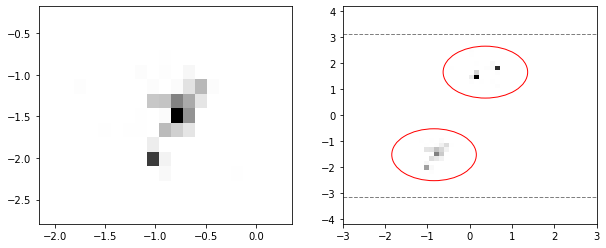

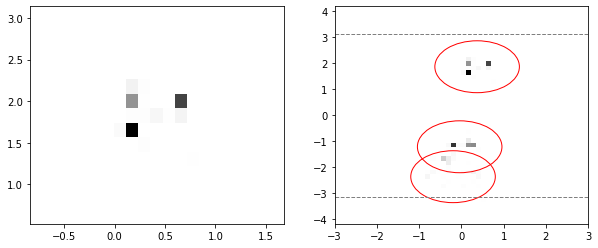

In [19]:
lhe_file_name = 'jets_tt/Events/run_01_decayed_1/unweighted_events.lhe.gz'
leading_jet_images, all_jet_images, jetpep = run_pythia_get_images(lhe_file_name, PTRANGE=[500,700], PTRANGE2=[450,700], nevents=50000, plot_first_few=True)

In [25]:
leading_jet_images[0][10]
len(leading_jet_images[0])

15

In [20]:
np.savez_compressed(outdir+'tt_leading_jet.npz', leading_jet_images)
np.savez_compressed(outdir+'tt_all_jets.npz', all_jet_images)
np.savez_compressed(outdir+'tt_jetpep.npz', jetpep)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/lib/npyio.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


Generate QCD jets, run through pythia and save corresponding jet images

In [17]:
! cd /Users/mghasemi/Desktop/Code-factory/Generator/MG5_aMC_v3_4_1/; bin/mg5_aMC $cwd/generate_qcd.mg5

************************************************************
*                                                          *
*                     W E L C O M E to                     *
*              M A D G R A P H 5 _ a M C @ N L O           *
*                                                          *
*                                                          *
*                 *                       *                *
*                   *        * *        *                  *
*                     * * * * 5 * * * *                    *
*                   *        * *        *                  *
*                 *                       *                *
*                                                          *
*         VERSION 3.5.3                 2023-12-23         *
*                                                          *
*    The MadGraph5_aMC@NLO Development Team - Find us at   *
*              http://madgraph.phys.ucl.ac.be/             *
*                       

0
10000
20000
30000
40000


<ipython-input-18-296b4edbae3c>:173: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return leading_jet_images, all_jet_images, np.array(jetpep)


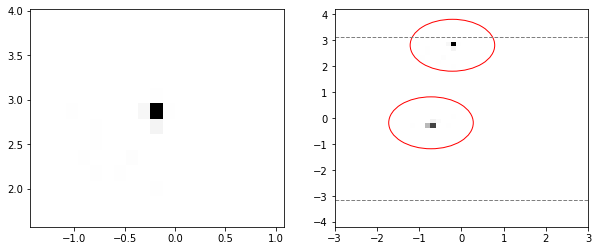

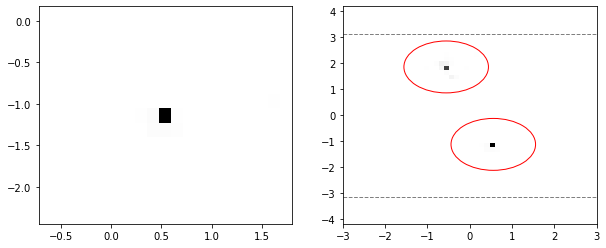

In [27]:
lhe_file_name = './jets_qcd/Events/run_01/unweighted_events.lhe.gz'
leading_jet_images, all_jet_images, jetpep = run_pythia_get_images(lhe_file_name, PTRANGE=[500,700], PTRANGE2=[450,700], nevents=50000, plot_first_few=True)

In [28]:
np.savez_compressed(outdir+'qcd_leading_jet.npz', leading_jet_images)
np.savez_compressed(outdir+'qcd_all_jets.npz', all_jet_images)
np.savez_compressed(outdir+'qcd_jetpep.npz', jetpep)

## plot some jets

In [32]:
leading_jet_images = np.load(outdir+'tt_leading_jet.npz', allow_pickle=True)['arr_0']
all_jet_images = np.load(outdir+'tt_all_jets.npz', allow_pickle=True)['arr_0']
jetpep = np.load(outdir+'tt_jetpep.npz', allow_pickle=True)['arr_0']

In [33]:
leading_jet_images0 = np.load(outdir+'qcd_leading_jet.npz', allow_pickle=True)['arr_0']
all_jet_images0 = np.load(outdir+'qcd_all_jets.npz', allow_pickle=True)['arr_0']
jetpep0 = np.load(outdir+'qcd_jetpep.npz', allow_pickle=True)['arr_0']

Pad leading jet images so they all have the same pixels.

In [39]:
std_jet_images0 = map(pad_image, leading_jet_images0)
std_jet_images = map(pad_image, leading_jet_images)

In [43]:
std_jet_images0

Plot a few events, first only the leading jet and then the whole event

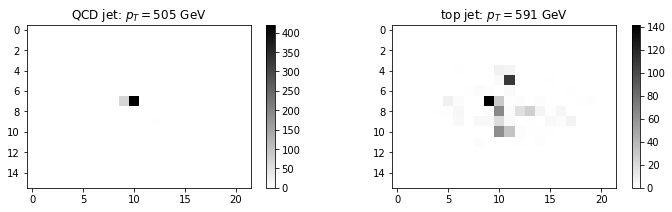

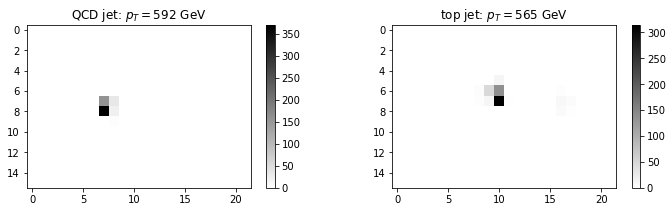

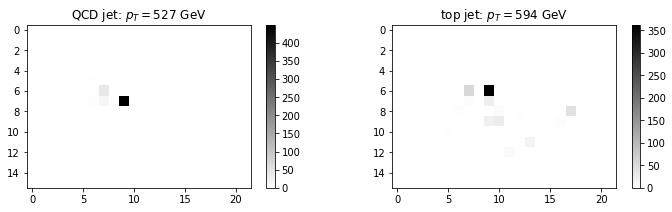

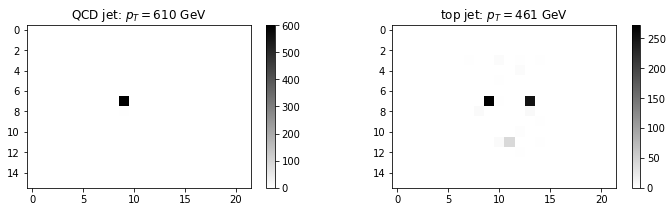

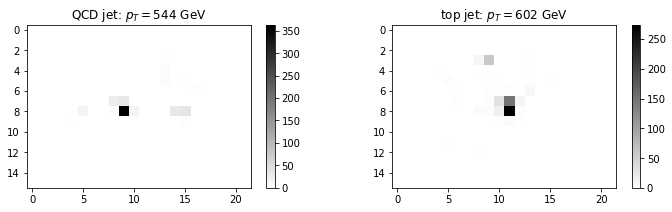

In [8]:
logscale = !True
logscale = dict(norm=mpl.colors.LogNorm()) if logscale else {}

for idx in range(5):
    fig, axes = plt.subplots(1,2, figsize=(12,3))
    for iax, ax in enumerate(axes):
        im = ax.imshow([std_jet_images0, std_jet_images][iax][idx], cmap=cmap, **logscale)
        plt.colorbar(im, ax=ax)

        ax.set(title='{} jet: $p_T=${:.0f} GeV'.format(['QCD','top'][iax], [jetpep0,jetpep][iax][idx][0][0]))

Normalizing the histogram values in 0-255 range: only differences are seen if I use log scale, in which case a bunch of soft energy deposits disappear. The classifier should not care about smaller changes (do not fit the noise!)

In [8]:
all_jet_images0 = map(normalize, all_jet_images0)
std_jet_images0 = map(normalize, std_jet_images0)

all_jet_images = map(normalize, all_jet_images)
std_jet_images = map(normalize, std_jet_images)

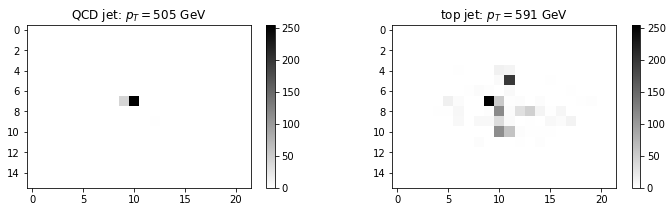

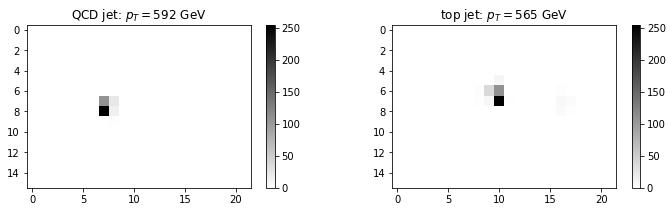

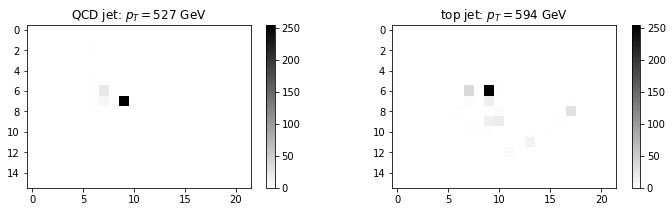

In [11]:
logscale = !True
logscale = dict(norm=mpl.colors.LogNorm()) if logscale else {}

for idx in range(3):
    fig, axes = plt.subplots(1,2, figsize=(12,3))    
    for iax, ax in enumerate(axes):
        im = ax.imshow([std_jet_images0, std_jet_images][iax][idx], cmap=cmap, **logscale)
        plt.colorbar(im, ax=ax)

        ax.set(title='{} jet: $p_T=${:.0f} GeV'.format(['QCD','top'][iax], [jetpep0,jetpep][iax][idx][0][0]))

Plotting whole events in the $\eta-\phi$ plane. Also draw a circle around each jet, with opacity set by jet pT

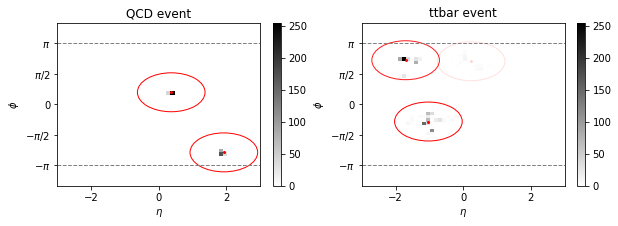

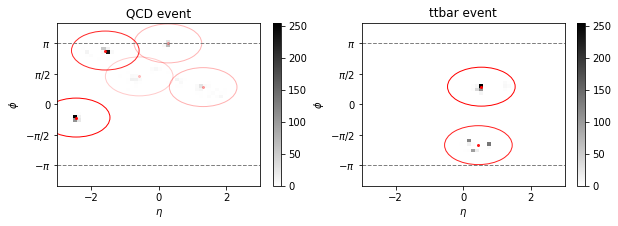

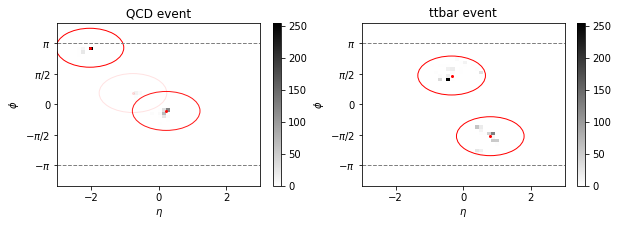

In [19]:
logscale = !True
logscale = dict(norm=mpl.colors.LogNorm()) if logscale else {}

for idx in range(3):
    fig, axes = plt.subplots(1,2, figsize=(10,3))    
    for iax, ax in enumerate(axes):
        im = ax.pcolor(etaedges, phiedges, sum([all_jet_images0, all_jet_images][iax][idx]), cmap=cmap, **logscale)
        plt.colorbar(im, ax=ax)
        jets = [jetpep0[idx], jetpep[idx]][iax]
        for j in jets:
            ax.add_artist(plt.Circle((j[1],j[2]),1, color='r', fill=False, alpha=j[0]/max([jj[0] for jj in jets])))
            ax.scatter(j[1],j[2], s=4, c='r', alpha=j[0]/max([jj[0] for jj in jets]))
        ax.set(title='{} event'.format(['QCD','ttbar'][iax]), xlabel='$\eta$', ylabel='$\phi$', yticks=np.linspace(-np.pi, np.pi,5), 
               yticklabels=['$-\pi$','$-\pi/2$',0,'$\pi/2$','$\pi$'])
        for h in [-np.pi, np.pi]: 
            ax.axhline(h, ls='--', lw=1, c='gray')

Compare average images:

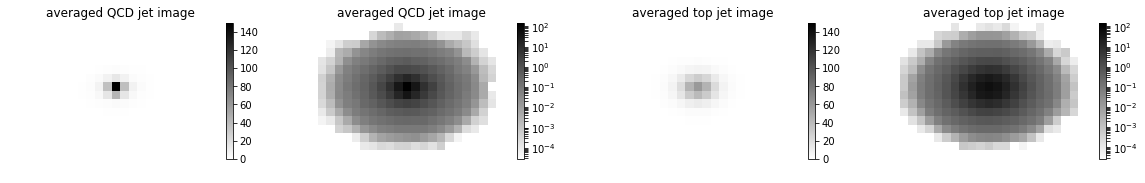

In [117]:
fig, axes = plt.subplots(1,4,figsize=(20,2.5))
ims = [0]*len(axes)
ims[0]=axes[0].imshow(np.average(std_jet_images0, axis=0), vmax=150,cmap=cmap)
ims[1]=axes[1].imshow(np.average(std_jet_images0, axis=0), vmax=150, norm=mpl.colors.LogNorm(),cmap=cmap)
ims[2]=axes[2].imshow(np.average(std_jet_images, axis=0), vmax=150,cmap=cmap)
ims[3]=axes[3].imshow(np.average(std_jet_images, axis=0), vmax=150, norm=mpl.colors.LogNorm(),cmap=cmap)

for iax, ax in enumerate(axes):
    plt.colorbar(ims[iax], ax=ax)
    ax.set_axis_off(); 
    ax.set(title='averaged {} jet image'.format(['QCD','top'][iax//2]))

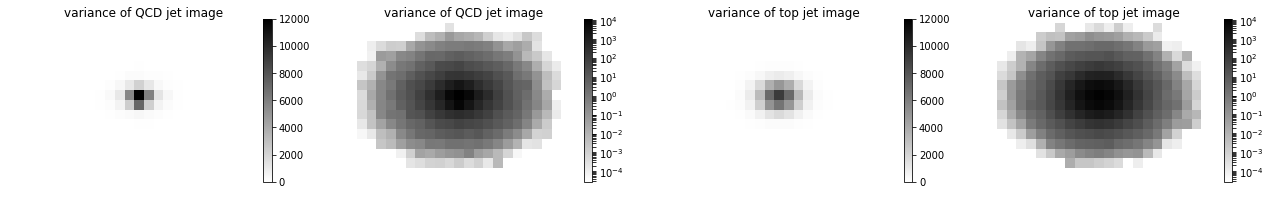

In [118]:
fig, axes = plt.subplots(1,4,figsize=(22,3))
ims = [0]*len(axes)
ims[0]=axes[0].imshow(np.var(std_jet_images0, axis=0), vmax=12000,cmap=cmap)
ims[1]=axes[1].imshow(np.var(std_jet_images0, axis=0), vmax=12000, norm=mpl.colors.LogNorm(),cmap=cmap)
ims[2]=axes[2].imshow(np.var(std_jet_images, axis=0), vmax=12000,cmap=cmap)
ims[3]=axes[3].imshow(np.var(std_jet_images, axis=0), vmax=12000, norm=mpl.colors.LogNorm(),cmap=cmap)

for iax, ax in enumerate(axes):
    plt.colorbar(ims[iax], ax=ax)
    ax.set_axis_off(); 
    ax.set(title='variance of {} jet image'.format(['QCD','top'][iax//2]))

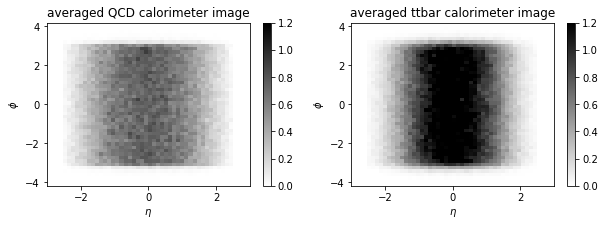

In [121]:
fig, axes = plt.subplots(1,2,figsize=(10,3))
ims = [0]*len(axes)
ims[0]=axes[0].pcolor(etaedges, phiedges, np.average(map(sum,all_jet_images0), axis=0), vmax=1.2,cmap=cmap)
ims[1]=axes[1].pcolor(etaedges, phiedges, np.average(map(sum,all_jet_images), axis=0), vmax=1.2,cmap=cmap)

for iax, ax in enumerate(axes):
    plt.colorbar(ims[iax], ax=ax)
    ax.set(xlabel='$\eta$',ylabel='$\phi$') 
    ax.set(title='averaged {} calorimeter image'.format(['QCD','ttbar'][iax]))

# Training neural networks

We will here train the neural networks for classifying between QCD jets and top quark jets. The trainig itself was done on a [Colab notebook](https://colab.research.google.com/) with TPU support to train the networks faster than on my laptop.

## run on Colab

In [9]:
import keras
data0 = np.load(outdir+'qcd_leading_jet.npz')['arr_0']
data1 = np.load(outdir+'tt_leading_jet.npz')['arr_0']

print('We have {} QCD jets and {} top jets'.format(len(data0), len(data1)))

x_data = np.concatenate((data0, data1))
# pad and normalize images
x_data = map(pad_image, x_data)
x_data = map(normalize, x_data)

y_data = np.array([0]*len(data0)+[1]*len(data1))

np.random.seed(0) # for reproducibility
x_data, y_data = np.random.permutation(np.array([x_data, y_data]).T).T

# the data coming out of previous commands is a list of 2D arrays. We want a 3D np array (n_events, xpixels, ypixels)
x_data = np.stack(x_data)

print(x_data.shape, y_data.shape)

# reshape for tensorflow: x_data.shape + (1,) = shortcut for (x_data.shape[0], 16, 22, 1)
x_data = x_data.reshape(x_data.shape + (1,)).astype('float32')
x_data /= 255.

y_data = keras.utils.to_categorical(y_data, 2)

print(x_data.shape, y_data.shape)

n_train = 50000
(x_train, x_test) = x_data[:n_train], x_data[n_train:]
(y_train, y_test) = y_data[:n_train], y_data[n_train:]

print('We will train+validate on {0} images, leaving {1} for cross-validation'.format(n_train,len(x_data)-n_train))

Using TensorFlow backend.


We have 35379 QCD jets and 36708 top jets
((72087, 16, 22), (72087,))
((72087, 16, 22, 1), (72087, 2))
We will train+validate on 50000 images, leaving 22087 for cross-validation


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D

In [ ]:
%%time
model0 = Sequential()
model0.add(Flatten(input_shape=(16, 22, 1)))  # Images are a 3D matrix, we have to flatten them to be 1D
model0.add(Dense(2, kernel_initializer='normal', activation='softmax'))

# Compile model
model0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_logi = model0.fit(x_train, y_train, validation_split=0.2, epochs=40, batch_size=100, shuffle=True, verbose=0)

In [ ]:
%%time
model1 = Sequential()
model1.add(Flatten(input_shape=(16, 22, 1)))  # Images are a 3D matrix, we have to flatten them to be 1D
model1.add(Dense(100, kernel_initializer='normal', activation='tanh'))
model1.add(Dropout(0.5)) # drop a unit with  50% probability.

model1.add(Dense(100, kernel_initializer='orthogonal',activation='tanh'))
model1.add(Dropout(0.5)) # drop a unit with  50% probability.

model1.add(Dense(100, kernel_initializer='orthogonal',activation='tanh'))
# model.add(Activation('sigmoid'))
model1.add(Dense(2, kernel_initializer='normal', activation='softmax')) # last layer, this has a softmax to do the classification

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_mlp = model1.fit(x_train, y_train, validation_split=0.2, epochs=40, batch_size=100, shuffle=True, verbose=1)

In [ ]:
%%time
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), input_shape=(16, 22, 1), activation='relu'))
model_cnn.add(Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_cnn.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))

model_cnn.add(Flatten())
model_cnn.add(Dense(300, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(2, activation='softmax'))

# Compile model
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history_cnn = model_cnn.fit(x_train, y_train, validation_split=0.2, epochs=40, batch_size=100, shuffle=True, verbose=1)

Save NN models and training histories:

In [ ]:
model_dir='trained_models_low_pt/'
if not os.path.isdir(model_dir): os.system('mkdir '+model_dir)
model0.save(model_dir+'logi.h5')
model1.save(model_dir+'mlp.h5')
model_cnn.save(model_dir+'cnn.h5')
np.savez(model_dir+'training_histories.npz', [ history.history for history in [history_logi, history_mlp, history_cnn ]])


## analyze

Download the trained models from Colab, load them and analyze training/ROC curves (mkae sure you have loaded and reshaped the train/test datasets above)

In [ ]:
model_dir='trained_models_low_pt/'

history_logi, history_mlp, history_cnn = np.load(model_dir+'training_histories.npz')['arr_0']
model0 = keras.models.load_model(model_dir+'logi.h5')
model1 = keras.models.load_model(model_dir+'mlp.h5')
model_cnn = keras.models.load_model(model_dir+'cnn.h5')

In [11]:
predictions0 = model0.predict(x_test)
predictions1 = model1.predict(x_test)
predictions_cnn = model_cnn.predict(x_test)

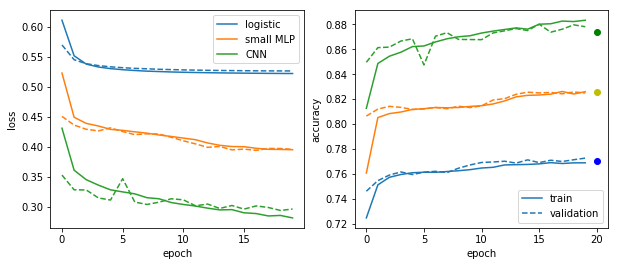

In [23]:
fig, axes = plt.subplots(1,2,figsize=(10,4))

nn=20
axes[1].scatter(nn, 1.*sum(np.argmax(predictions0, axis=1) == np.argmax(y_test, axis=1))/ len(y_test),c='b')
axes[1].scatter(nn, 1.*sum(np.argmax(predictions1, axis=1) == np.argmax(y_test, axis=1))/ len(y_test),c='y')
axes[1].scatter(nn, 1.*sum(np.argmax(predictions_cnn, axis=1) == np.argmax(y_test, axis=1))/ len(y_test),c='g')
for i, history in enumerate([history_logi, history_mlp, history_cnn]):
    axes[1].plot(history['acc'][:nn], c=plt.get_cmap("tab10")(i), label='train')
    axes[1].plot(history['val_acc'][:nn], c=plt.get_cmap("tab10")(i), ls ='--', label='validation')
    axes[0].plot(history['loss'][:nn], c=plt.get_cmap("tab10")(i), label=['logistic','small MLP', 'CNN', 'CNN v2'][i])
    axes[0].plot(history['val_loss'][:nn], c=plt.get_cmap("tab10")(i), ls='--')
for iax in range(2):
    axes[iax].set(xlabel='epoch', ylabel=['loss','accuracy'][iax])
axes[0].legend()
axes[1].legend(['train','validation']);
fig.savefig('training_history.png')

In [24]:
from sklearn.metrics import roc_curve
fpr0, tpr0, thresholds = roc_curve(y_test.ravel(), predictions0.ravel())
fpr1, tpr1, thresholds = roc_curve(y_test.ravel(), predictions1.ravel())
fpr_cnn, tpr_cnn, thresholds = roc_curve(y_test.ravel(), predictions_cnn.ravel())

from sklearn.metrics import auc
auc0 = auc(fpr0, tpr0)
auc1 = auc(fpr1, tpr1)
auc2 = auc(fpr_cnn, tpr_cnn)

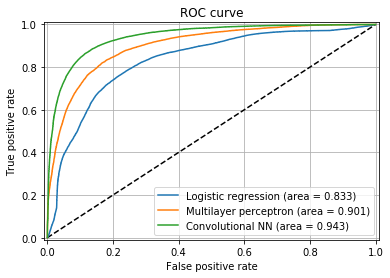

In [25]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr0, tpr0, label='Logistic regression (area = {:.3f})'.format(auc0))
plt.plot(fpr1, tpr1, label='Multilayer perceptron (area = {:.3f})'.format(auc1))
plt.plot(fpr_cnn, tpr_cnn, label='Convolutional NN (area = {:.3f})'.format(auc2))
plt.gca().set(xlabel='False positive rate', ylabel='True positive rate', title='ROC curve', xlim=(-0.01,1.01), ylim=(-0.01,1.01))
plt.grid(True, which="both")
plt.legend(loc='lower right');
plt.savefig('ROC_curve.png')

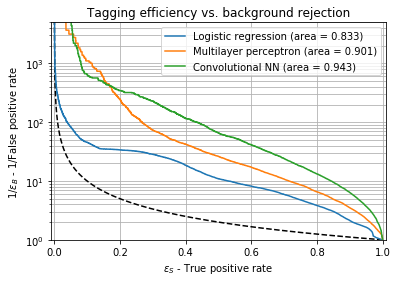

In [26]:
np.seterr(divide='ignore', invalid='ignore') # disable warning for 1/0 divisions
plt.plot(thresholds, 1/thresholds, 'k--')
plt.plot(tpr0, 1/fpr0, label='Logistic regression (area = {:.3f})'.format(auc0))
plt.plot(tpr1, 1/fpr1, label='Multilayer perceptron (area = {:.3f})'.format(auc1))
plt.plot(tpr_cnn, 1/fpr_cnn, label='Convolutional NN (area = {:.3f})'.format(auc2))
plt.gca().set(ylabel='1/$\epsilon_B$ - 1/False positive rate', xlabel='$\epsilon_S$ - True positive rate', title='Tagging efficiency vs. background rejection', xlim=(-0.01,1.01), ylim=(1,5*10**3), yscale='log')
plt.grid(True, which="both")
plt.legend(loc='upper right');
plt.savefig('ROC_curve_bg_rej.png')

Check most certain and most uncertain NN predictions. Also check when the NN is most certain of its failed predictions

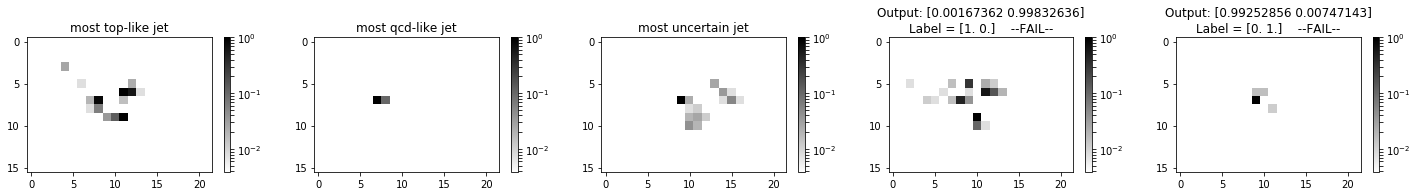

In [139]:
logscale = True
logscale = dict(norm=mpl.colors.LogNorm()) if logscale else {}

fig, axes = plt.subplots(1,5,figsize=(20,2.5))
for i in range(2):
    im = axes[i].imshow(x_test[predictions_cnn.argmin(axis=0)[i],:,:,0], vmax=1, cmap=cmap, **logscale)
    plt.colorbar(im, ax=axes[i])
    axes[i].set(title='most {}-like jet'.format(['top','qcd'][i]))
axes[2].imshow(x_test[abs(predictions_cnn-0.5).argmin(axis=0)[0],:,:,0], vmax=1, cmap=cmap, **logscale)
plt.colorbar(im, ax=axes[2])
axes[2].set(title='most uncertain jet');

for iax, i in enumerate((predictions_cnn - y_test).argmin(axis=0)):
    im = axes[iax+3].imshow(x_test[i,:,:,0], vmax=1, cmap=cmap, **logscale)
    plt.colorbar(im, ax=axes[iax+3])
    axes[iax+3].set_title('Output: {}\nLabel = {}    --FAIL--'.format(predictions_cnn[i], y_test[i]))

fig.tight_layout()
fig.savefig('cnn_jet_sample.png', dpi=150)

What does the model think of an empty image?

In [34]:
empty = np.zeros(x_test[0].shape)
[model.predict(np.array([empty])) for model in [model0, model1, model_cnn]]

[array([[0.7229311 , 0.27706897]], dtype=float32),
 array([[0.6891926 , 0.31080747]], dtype=float32),
 array([[0.9867889, 0.013211 ]], dtype=float32)]

Not great! Looks a lot like a QCD jet! Because the only difference from a sharp QCD jet is in one or a few pixels! Bad CNN! 

In real world applications, one would need to make sure they are passing images with at least one hot pixel. For example, see the image brightness:

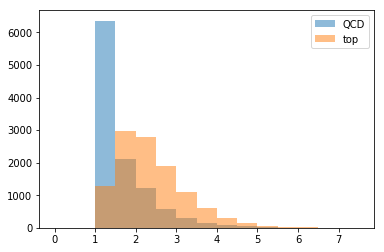

In [55]:
plt.hist(map(np.sum, [ x for x,y in zip(x_test, y_test)[:] if np.argmax(y)==0] ), bins=np.arange(0,8,0.5), alpha=0.5, label='QCD')
plt.hist(map(np.sum, [ x for x,y in zip(x_test, y_test)[:] if np.argmax(y)==1] ), bins=np.arange(0,8,0.5), alpha=0.5, label='top')
plt.legend();

### Check effect of pixel normalization

Trained models without normalizing the data. Any difference? Reload data but skip normalization step

In [299]:
data0 = np.load(outdir+'qcd_leading_jet.npz')['arr_0']
data1 = np.load(outdir+'tt_leading_jet.npz')['arr_0']

print('We have {} QCD jets and {} top jets'.format(len(data0), len(data1)))

x_data = np.concatenate((data0, data1))
# pad images
x_data = map(pad_image, x_data)
# x_data = map(normalize, x_data)

y_data = np.array([0]*len(data0)+[1]*len(data1))

np.random.seed(0) # for reproducibility
x_data, y_data = np.random.permutation(np.array([x_data, y_data]).T).T

# the data coming out of previous commands is a list of 2D arrays. We want a 3D np array (n_events, xpixels, ypixels)
x_data = np.stack(x_data)

print(x_data.shape, y_data.shape)

# reshape for tensorflow: x_data.shape + (1,) = shortcut for (x_data.shape[0], 16, 22, 1)
x_data = x_data.reshape(x_data.shape + (1,)).astype('float32')/255.

y_data = keras.utils.to_categorical(y_data, 2)

print(x_data.shape, y_data.shape)

n_train = 50000
(x_train_no, x_test_no) = x_data[:n_train], x_data[n_train:]
(y_train_no, y_test_no) = y_data[:n_train], y_data[n_train:]

print('We will train+validate on {0} images, leaving {1} for cross-validation'.format(n_train,len(x_data)-n_train))

We have 35379 QCD jets and 36708 top jets
((72087, 16, 22), (72087,))
((72087, 16, 22, 1), (72087, 2))
We will train+validate on 50000 images, leaving 22087 for cross-validation


Training happened via Colab... load saved CNN model

In [300]:
model_dir='trained_models_low_pt/'
model_cnn_no = keras.models.load_model(model_dir+'cnn_no_norm.h5')

In [301]:
predictions_cnn_no = model_cnn_no.predict(x_test_no)

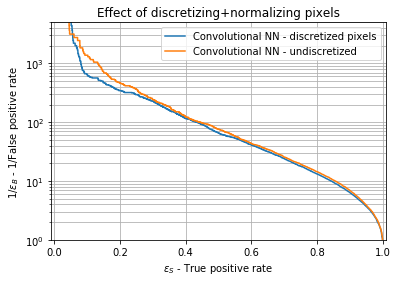

In [302]:
fpr_cnn_no, tpr_cnn_no, thresholds = roc_curve(y_test_no.ravel(), predictions_cnn_no.ravel())

np.seterr(divide='ignore', invalid='ignore') # disable warning for 1/0 divisions
plt.plot(tpr_cnn, 1/fpr_cnn, label='Convolutional NN - discretized pixels')
plt.plot(tpr_cnn_no, 1/fpr_cnn_no, label='Convolutional NN - undiscretized')
plt.gca().set(ylabel='1/$\epsilon_B$ - 1/False positive rate', xlabel='$\epsilon_S$ - True positive rate', title='Effect of discretizing+normalizing pixels', xlim=(-0.01,1.01), ylim=(1,5*10**3), yscale='log')
plt.grid(True, which="both")
plt.legend(loc='upper right');

### Compare to high pT jets

We have also generated jets at higher momentum, in the 800-900 GeV range. In this case the jets will are more boosted, so that all the top decay products typically fall within the $\Delta R=1$ jet cone. We can train the models on these images and re-train the models, and compare.

In [313]:
import keras
data0 = np.load(outdir+'qcd_high_leading_jet.npz')['arr_0']
data1 = np.load(outdir+'tt_high_leading_jet.npz')['arr_0']

print('We have {} QCD jets and {} top jets'.format(len(data0), len(data1)))

x_data = np.concatenate((data0, data1))
# pad and normalize images
x_data = map(pad_image, x_data)
# x_data = map(normalize, x_data)

y_data = np.array([0]*len(data0)+[1]*len(data1))

np.random.seed(0) # for reproducibility
x_data, y_data = np.random.permutation(np.array([x_data, y_data]).T).T

# the data coming out of previous commands is a list of 2D arrays. We want a 3D np array (n_events, xpixels, ypixels)
x_data = np.stack(x_data)

print(x_data.shape, y_data.shape)

# reshape for tensorflow
x_data = x_data.reshape(x_data.shape[0], 16, 22, 1)
x_data = x_data.astype('float32')
x_data /= 255.

y_data = keras.utils.to_categorical(y_data, 2)

print(x_data.shape, y_data.shape)

n_train = 40000 # less events in this dataset!
(x_trainH, x_testH) = x_data[:n_train], x_data[n_train:]
(y_trainH, y_testH) = y_data[:n_train], y_data[n_train:]

print('We will train+validate on {0} images, leaving {1} for cross-validation'.format(n_train,len(x_data)-n_train))

We have 24395 QCD jets and 24561 top jets
((48956, 16, 22), (48956,))
((48956, 16, 22, 1), (48956, 2))
We will train+validate on 40000 images, leaving 8956 for cross-validation


In [314]:
model_dir='trained_models_high_pt/'

model1H = keras.models.load_model(model_dir+'mlp.h5')
model_cnnH = keras.models.load_model(model_dir+'cnn.h5')

In [315]:
predictions1H = model1H.predict(x_testH)
predictions_cnnH = model_cnnH.predict(x_testH)

In [316]:
from sklearn.metrics import roc_curve
fpr1H, tpr1H, thresholds = roc_curve(y_testH.ravel(), predictions1H.ravel())
fpr_cnnH, tpr_cnnH, thresholds = roc_curve(y_testH.ravel(), predictions_cnnH.ravel())

from sklearn.metrics import auc
auc1H = auc(fpr1H, tpr1H)
auc2H = auc(fpr_cnnH, tpr_cnnH)

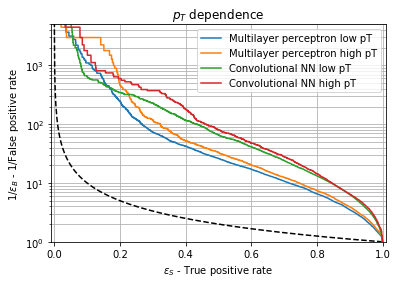

In [320]:
np.seterr(divide='ignore', invalid='ignore') # disable warning for 1/0 divisions
plt.plot(thresholds, 1/thresholds, 'k--')
plt.plot(tpr1, 1/fpr1, label='Multilayer perceptron low pT')
plt.plot(tpr1H, 1/fpr1H, label='Multilayer perceptron high pT')
plt.plot(tpr_cnn, 1/fpr_cnn, label='Convolutional NN low pT ')
plt.plot(tpr_cnnH, 1/fpr_cnnH, label='Convolutional NN high pT')
plt.gca().set(ylabel='1/$\epsilon_B$ - 1/False positive rate', xlabel='$\epsilon_S$ - True positive rate', title='$p_T$ dependence', xlim=(-0.01,1.01), ylim=(1,5*10**3), yscale='log')
plt.grid(True, which="both")
plt.legend();

We see that high-pT jets are slightly better classified, but not by a big margin